# Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as f
import pandas as pd
import numpy as np

# Setting Hyperparameters

In [2]:
batch_size = 32
block_size = 10
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

# Loading and Preprocessing Text Data

In [3]:
with open('poems.txt', 'r', encoding='latin-1') as file:
    text = file.readlines()

In [4]:
with open('poems.txt', 'r', encoding='utf-8', errors='ignore') as file:
    text = file.readlines()

In [5]:
# take only the 50% of the data
text = text[:int(len(text)*0.001)]

In [6]:
text[:10]

['خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا    وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا\n',
 'فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ    وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى\n',
 'وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً    وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا\n',
 'لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ    تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا\n',
 'وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ    وَأَفرَعَ في لَومي مِراراً وَأَصعَدا\n',
 'عَلى غَيرِ ذَنبٍ أَن أَكونَ جَنَيتُهُ    سِوى قَولِ باغٍ كادَني فَتَجَهَّدا\n',
 'لَعَمري لَنِعمَ المَرءُ تَدعو بِحَبلِهِ    إِذا ما المُنادي في المَقامَةِ نَدَّدا\n',
 'عَظيمُ رَمادِ القِدرِ لا مُتَعَبِّسٌ    وَلا مُؤيِسٌ مِنها إِذا هُوَ أَوقَدا\n',
 'وَإِن صَرَّحَت كَحلٌ وَهَبَّت عَرِيَّةٌ    مِنَ الريحِ لَم تَترُك لِذي المالِ مِرفَدا\n',
 'صَبَرتُ عَلى وَطءِ المَوالي وَحَطمِهِم    إِذا ضَنَّ ذو القُربى عَلَيهِم وَأَخمَدا\n']

In [7]:
# Remove the newline characters from each line
text = [t.strip() for t in text]
poemslist = list(set(text))

# Tokenizing and Encoding Data

In [8]:
import nltk
nltk.download('punkt')  # Download necessary resources
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
tokens = [word_tokenize(poem) for poem in poemslist]
flat_tokens = [word for sublist in tokens for word in sublist]

# Creating a set of unique words
unique_words = sorted(set(flat_tokens))
len(unique_words)

8556

In [10]:
# Create word to index and index to word mappings (encoding and decoding)
word_to_idx = {word: idx for idx, word in enumerate(unique_words)}
idx_to_word = {idx: word for idx, word in enumerate(unique_words)}

In [11]:
# Encode each tokenized poem
encoded_poems = lambda flat_tokens: [word_to_idx[word] for word in flat_tokens]
# Decode each encoded poem
decoded_poems = lambda tokens: ' '.join([idx_to_word[idx] for idx in tokens])

In [12]:
data = torch.tensor(encoded_poems(flat_tokens), dtype=torch.long)

# Splitting Data into Training and Validation Sets

In [13]:
traning_set_size = int(0.9*len(data))
train_data = data[:traning_set_size]
val_data = data[traning_set_size:]

# Defining Function to Generate Random Batches

In [14]:
def generateRandomBatch(mode):
    data = train_data if mode == 'train' else val_data
    starting_indexes = torch.randint(0,len(data)-block_size,(batch_size,))
    x = torch.stack([data[i:i+block_size] for i in starting_indexes])
    y = torch.stack([data[i+1:i+block_size+1] for i in starting_indexes])
    x, y = x.to(device), y.to(device)
    return x, y

# Defining Bigram Language Model
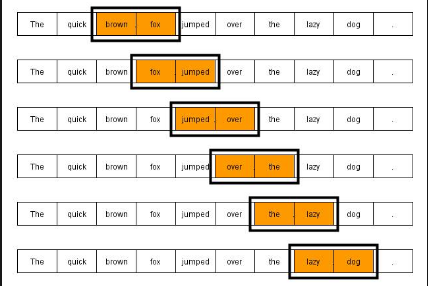

In [15]:
# implemented by Andrej Karpathy
class BigramLanguageModel(nn.Module):
    def __init__(self, word_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(word_size, word_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = f.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = f.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# Initializing Model and Optimizer

In [16]:
model = BigramLanguageModel(len(unique_words))
m = model.to(device)

# Training the Model

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
for iter in range(max_iters):
    # sample a batch of data
    xb, yb = generateRandomBatch('train')
    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(9.6220, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5984, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.4920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.6067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.6080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.4968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.4998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5610, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.4954, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(9.5487, device='cuda:0', grad_fn=

# Generating Text with the Trained Model

In [22]:
# get random encodded word from string ''
s = flat_tokens[42]
print(s)
encoded_s = encoded_poems([s])
context = torch.zeros((1, 1), dtype=torch.long, device=device)
context[0, 0] = encoded_s[0]
print(decoded_poems(m.generate(context, max_new_tokens=10)[0].tolist()))

نَدى
نَدى كَفَّيكَ وَالنَسَبُ القُرابُ وَيُخشى عُبابُ البَحرِ ناجِ وَمَتى وَنَت وَأَبو


# Saving the Model

In [ ]:
# access my google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_path = 'drive/MyDrive/trained_model2.pth'
torch.save(model.state_dict(), model_path)